In [1]:
# Original https://bm371613.github.io/conditional-flow-matching/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
from torch import nn
from tqdm import tqdm
from zuko.utils import odeint

plt.rcParams["animation.html"] = "jshtml"

torch.cuda.set_device(0)

In [2]:
# Creates a dataset of complex points in the shape of a happy face :)
def create_dataset(size: int = 100_000):
    # Creates a set of complex points of magnitude 1 (unit circle) and random phase, essentialy lots of points in the unit circle
    complex_points = torch.polar(torch.tensor(1.0), torch.rand(size) * 2 * torch.pi)
    # Stacks the real and imaginary parts of the complex points, so that each row is a complex number
    X = torch.stack((complex_points.real, complex_points.imag)).T
    
    # Moves all the points on the upper side of the circle to 2 points (eyes)
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5

    # Adds noise to the points, more noise to the upper points for the eyes and less noise to the lower points for the mouth
    noise = torch.zeros_like(X)
    noise[upper] = torch.randn_like(noise[upper]) * 0.10
    noise[~upper] = torch.randn_like(noise[~upper]) * 0.05
    X += noise
    
    # Normalizes the data so it has 0 mean and 1 std
    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    return X + noise
    
dataset = create_dataset()
noise = torch.randn_like(dataset)

dataset.shape

torch.Size([100000, 2])

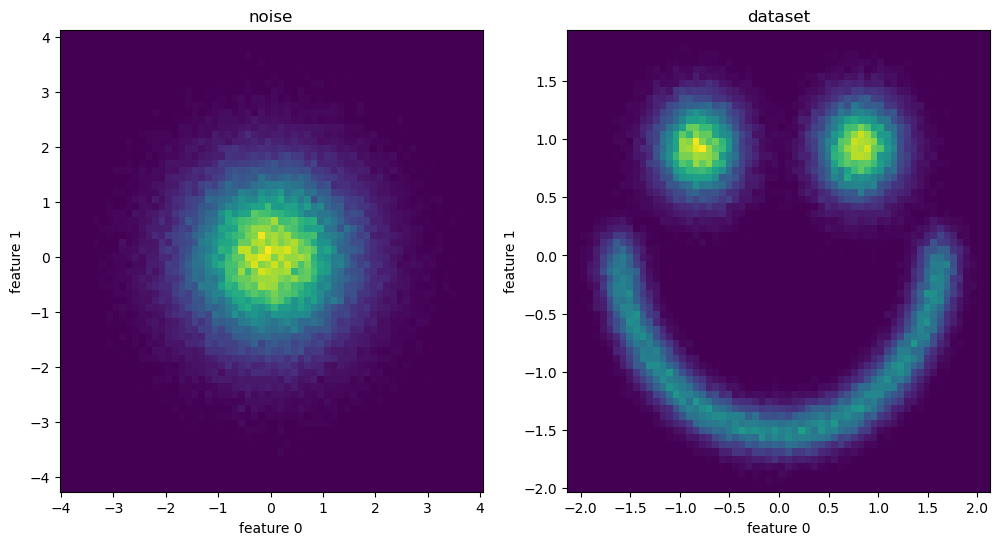

In [3]:
# Plots the dataset
def plot_dataset(X, bins, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.hist2d(*X.T, bins=bins)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_dataset(noise, bins=64, ax=axs[0], title='noise')
plot_dataset(dataset, bins=64, ax=axs[1], title='dataset')

In [4]:
# From the original notebook:
# Let's consider a process of data transformation with time flowing from 0 to 1.
# At 0, we start with the random noise. At 1, we hope to arrive at the target distribution - our dataset.

#For every
#   time value between 0 and 1
#   point in our feature space
# the flow model specifies a change in a particula direction in the feature space.

class FlowModel(nn.Module):

    def forward(self, X, time):
        raise NotImplementedError()

class ExampleFlow(FlowModel):

    def forward(self, X, time):
        result = torch.zeros_like(X)
        result[:, 0] = -X[:, 0] * time
        result[:, 1] = X[:, 1] * (1 - time)
        return result

ExampleFlow()(torch.tensor([[.2, .4], [.7, .9]]), time=torch.tensor([.6]))

tensor([[-0.1200,  0.1600],
        [-0.4200,  0.3600]])

In [5]:
# Flow visualization

@torch.no_grad()
def plot_flow_at_time(flow_model, time, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    points = torch.linspace(-1, 1, 10)
    flow_input = torch.cartesian_prod(points, points) # grid of points
    flow_output = flow_model(flow_input, time=torch.full((flow_input.shape[0],), time)) # x and t are the same number of elements
    ax.quiver(
        torch.stack(torch.chunk(flow_input[:, 0], len(points))).numpy(), # input real coordinates
        torch.stack(torch.chunk(flow_input[:, 1], len(points))).numpy(), # input imaginary coordinates
        torch.stack(torch.chunk(flow_output[:, 0], len(points))).numpy(), # output real coordinates
        torch.stack(torch.chunk(flow_output[:, 1], len(points))).numpy(), # output imaginary coordinates
        scale=len(points),
    )
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)


def animate_flow(flow_model, frames: int = 20):

    def plot_frame(time):
        plt.cla()
        plot_flow_at_time(flow_model, time=time, title=f'flow at time={time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html
    
animate_flow(ExampleFlow())

### Notes on Differential Equations and flow visualization

* The flow model can be seen as a Differential Equations system, where the flow model is a function of the rate of change (derivative) of the initial data distribution x_0
* Given that the flow model is a first order diferential equation, is an Ordinary Differential Equation (ODE), i.e the differential equation has no partial derivatives
* We need to solve the diferential equation system with initial conditions x_0 and t_0 to get the new data distribution function phi(x) evaluated a t_1 to get the final data distribution x_1 to visualize the change of distributuion. An ODE solver (zuko.odeint) is used for this 

In [6]:
# Visualize the flow of the gaussian noise dataset through the flow model

@torch.no_grad()
def run_flow(flow_model, x_0, t_0, t_1, device='cpu'):
    def f(t: float, x):
        return flow_model(x, time=torch.full(x.shape[:1], t, device=device))

    #Ordinart differential equation solver, gives the solving function evaluated at time t_1 to get the new data distribution.
    return odeint(f, x_0, t_0, t_1, phi=flow_model.parameters()) 


def animate_flow_run(flow_model, X, frames=20, device='cpu'):
    bins = [
        np.linspace(X[:, 0].min().cpu(), X[:, 0].max().cpu(), 128),
        np.linspace(X[:, 1].min().cpu(), X[:, 1].max().cpu(), 128),
    ]

    def plot_frame(time):
        plt.cla()
        plot_dataset(run_flow(flow_model, X, 0, time, device=device).cpu(), bins=bins, title=f'distribution at time {time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html


animate_flow_run(ExampleFlow(), noise)

In [7]:
# Trainable neural network flow model

class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        # t: (# points in the grid,) 

        # ... list all the dimensions before the last one, None adds a new dimension
        emb = self.freqs * t[..., None] # (num points in the gris (10x10), dim // 2 + 1)) by broadcasting
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1) # (num points in the grid, (dim // 2 + 1) * 2)
        return emb


class FlowNeuralNetwork(FlowModel):

    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        # x: (num points, num features) (100,2)
        # time: (num points,) (100,), all with the same time value

        X = torch.cat([X, self.time_embedding(time)], axis=1) # (num points (100), num features + time_embedding_size (2 + 8))
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

In [8]:
# Visualize the flow with parameters initialized randomly

model = FlowNeuralNetwork(n_features=2)
animate_flow(model)

In [9]:
animate_flow_run(model.cuda(), noise.cuda(), device='cuda')

# Training

The conditional flow matching loss works as follows:

* We are given some data points
* For every data point we randomly choose a time value t between 0 and 1
* We calculate x_t, which is a linear interpolation between gaussian noise and the data points
* We define the optimal flow as pointing from the sampled noise straight at the corresponding data points
* The loss is the mean square difference between the optimal flow and what the flow model outputs


In [10]:
def conditional_flow_matching_loss(flow_model, x):
    sigma_min = 1e-4 # To avoid numerical instability
    t = torch.rand(x.shape[0], device=x.device) # generate random time values for each point in the dataset
    noise = torch.randn_like(x) # generate noise for each point in the dataset, with zero mean and unit variance
    
    # x_t at time zero has more noise, the more time passes, the less noise it has and it is closer to the dataset 
    
    # (1 − ( 1 − σmin​) ⋅ t) ⋅ noise: This term scales the noise by a factor that depends on t. When t is small, 
    # this factor is close to 1, meaning the noise has a significant impact on x_t​. As t increases, 
    # the factor decreases, reducing the influence of noise.

    #t ⋅ x: This term scales the original data x by t. When t is small, this term has little impact, but as t increases, 
    # this term approaches x, making x_t​ more similar to x.

    x_t = (1 - (1 - sigma_min) * t[:, None]) * noise + t[:, None] * x
    
    
    # This represents the "ideal" transformation that the model should learn to match. 
    # It essentially tells the model how to adjust from the noisy data x_t​ back to the original data x.
    optimal_flow = x - (1 - sigma_min) * noise

    predicted_flow = flow_model(x_t, time=t)

    loss = (predicted_flow - optimal_flow).square().mean()
    return loss

model.cuda().train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in tqdm(range(10_000)):
    model.zero_grad()
    loss = conditional_flow_matching_loss(model, create_dataset(10000).cuda())
    loss.backward()
    optimizer.step()

model = model.eval()
pass

100%|██████████| 10000/10000 [00:36<00:00, 274.83it/s]


In [11]:
animate_flow(model.cpu())

In [12]:
animate_flow_run(model.cuda(), noise.cuda(), device='cuda')

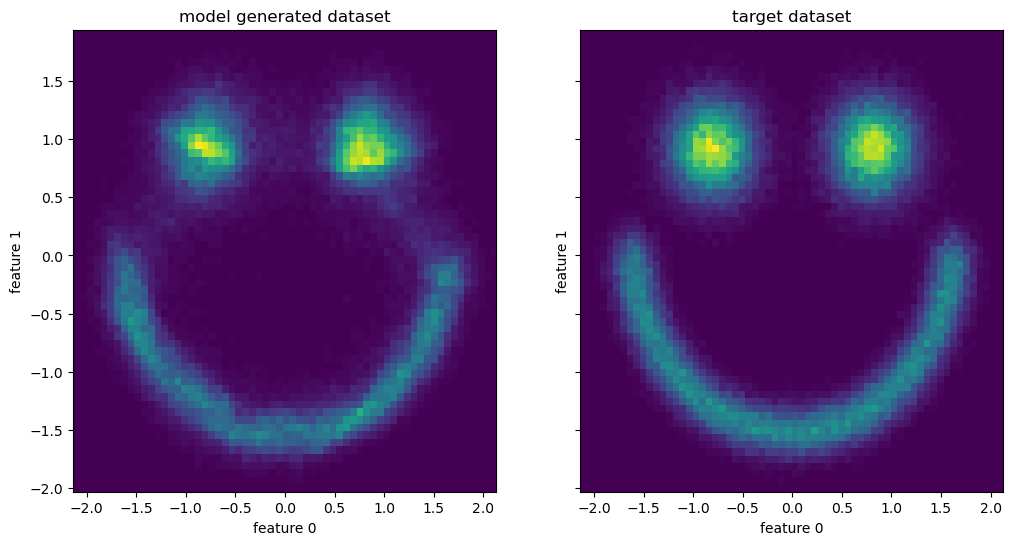

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
plot_dataset(run_flow(model.cuda(), noise.cuda(), 0, 1, device='cuda').cpu(), bins=64, ax=axs[0], title='model generated dataset')
plot_dataset(dataset, bins=64, ax=axs[1], title='target dataset')